# Visualize ranges of fluxes across samples - REDS Recall, ATP11C V972M
## Setup
### Import packages

In [ ]:
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    read_cobra_model,
    show_versions,
    ensure_iterable,
)
from rbc_gem_utils.visualization import cmap_map

from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PROTEOME_COMPARTMENT,
    DEFAULT_PREFIX_SUFFIX_VALUES,
    add_relaxation_budget,
    load_overlay_model,
    EnzymeDilution,
)
plt.rcParams["font.family"] = "Arial"
show_versions()



Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.3
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.4
openpyxl                              3.1.5
pandas                                2.3.1
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.4
scikit-learn                          1.7.0
scipy                                1.16.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip          25.1
setuptools 78.1.1
wheel      0.45

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e-8, 1e8)
COBRA_CONFIGURATION.tolerance = 1e-9
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-09
lower_bound,Default reaction lower bound,-1e-08
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "REDSRecall"
genotype = "ATP11C_V972M"
grouped_data_key = f'{genotype}_Sample'
grouped_data_key

'ATP11C_V972M_Sample'

### Set variables for sample identification

In [4]:
sample_key = "SAMPLE ID"
donor_key = "PUBLIC RECALL DONOR ID"

# For sample IDs
donor_re = re.compile(rf"(?P<donor>S(?P<num>\d\d\d))")
operations = "|".join([x.capitalize() for x in ["mean", "median"]])
operation_re = re.compile(r"(?P<op>" + operations + r")\_(?P<group>\w+)")
sample_id_re = re.compile(
    r"(?!" + operations + r")" + donor_re.pattern + r"\_"
)

### Set computation options

In [5]:
ftype = "xml"  # In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
run_computations = True  # Keep off to use previously computed results
overwrite = False  # Whether to allow overwriting of previous simulation results
verbose = True

# Objective reactions
objective_reactions = ["NaKt"] 
# Reactions that must have the capability to carry flux, sort for consistency
required_flux_reactions = ["PSFLIPt"] # Add reactions to this list
required_flux_reactions = sorted(set(objective_reactions + required_flux_reactions))


#### Set prefixes/suffixes to expect

In [6]:
protein_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.dilution"]
protein_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.metabolite"]
relaxation_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.relaxation"]
enzyme_met_suffix_total = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["suffix.total"]
enzyme_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.dilution"]
enzyme_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.metabolite"]
budget_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.dilution"]
budget_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.metabolite"]
comp_suffix = f"_{DEFAULT_PROTEOME_COMPARTMENT}"

### Set figure options

In [7]:
save_figures = True
transparent = False
imagetype = "svg"

### Set paths

In [8]:
# Set paths
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id
results_dirpath = (get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name / grouped_data_key)
pcfva_results_dirpath = (results_dirpath / "pcFVA" / "_".join(("REQ", *required_flux_reactions)) /  "_".join(("OBJ", *objective_reactions)))
# Objective reaction does not matter since correlations are computed
# based on min and max fluxes and abundance, which are obtained when optimum is 0.
corr_results_dirpath = results_dirpath / "correlations"

## Load RBC-GEM model

In [9]:
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

# Add relaxation budget to initial PC model to get names of relaxation reactions
add_relaxation_budget(pcmodel, 0, verbose=False)
pcmodel

Set parameter Username
Set parameter LicenseID to value 2664191
Academic license - for non-commercial use only - expires 2026-05-12


Name,RBC_GEM_PC
Memory address,29ff0533850
Number of metabolites,7815
Number of reactions,15687
Number of genes,723
Number of groups,68
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load pcFVA generated results

In [10]:
# Load DataFrame of generated results
df_pcfva_all = pd.read_csv(
    pcfva_results_dirpath / f"{pcmodel.id}_All_FVAsols.zip",
    index_col=None,
).fillna(0)

df_pcfva_all

,reactions,model,optimum,min,max
0,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688
1,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C1,0.0,0.000000,0.015410
2,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C10,0.0,0.000000,0.014478
3,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C11,0.0,0.000000,0.013896
4,1SGTH2OHE1ABCte,RBC_GEM_PC_Allele0_C12,0.0,0.000000,0.011391
...,...,...,...,...,...
123875,XYLU_Dt,RBC_GEM_PC_Mean_Allele1,0.0,-0.040705,0.040236
123876,XYLU_Dt,RBC_GEM_PC_Mean_Allele2,0.0,-0.053735,0.052435
123877,XYLU_Dt,RBC_GEM_PC_Median_Allele0,0.0,-0.037787,0.036772
123878,XYLU_Dt,RBC_GEM_PC_Median_Allele1,0.0,-0.040307,0.040021


## Create DataFrame for visualization
### Get maximum reaction fluxes and associated abundance values
#### Get maximum reaction fluxes and flux ranges

In [11]:
rxns = model.reactions.list_attr("id")
df_max_flux_per_model = df_pcfva_all[df_pcfva_all["reactions"].isin(rxns)].copy()
df_max_flux_per_model = df_max_flux_per_model.groupby(["model", "reactions", "optimum"])[["min", "max"]].agg(
    {
        "min": "min", # Minimum reaction flux per model
        "max": "max", # Maximum reaction flux per model
    }
)
# Address issues possibly caused by floating point precision, ideally a value that prevents any negative ranges
df_max_flux_per_model.loc[df_max_flux_per_model["max"] < df_max_flux_per_model["min"], ["max", "min"]] = [0, 0]
atol = COBRA_CONFIGURATION.tolerance
df_max_flux_per_model["max"] = df_max_flux_per_model["max"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_flux_per_model["min"] = df_max_flux_per_model["min"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_flux_per_model["range"] = df_max_flux_per_model["max"] - df_max_flux_per_model["min"]
# Ensure no negative values, if results appear then tolerance should be adjusted
df_max_flux_per_model[df_max_flux_per_model["range"] < 0]

,,,min,max,range
model,reactions,optimum,,,


#### Get maximum "enzyme" abundances

In [12]:
rxns = pcmodel.reactions.query(
    lambda x: isinstance(x, EnzymeDilution) and x.id.endswith(f"{enzyme_met_suffix_total}{comp_suffix}")
).list_attr("id")
df_max_abundance_per_model = df_pcfva_all[df_pcfva_all["reactions"].isin(rxns)].copy()
# Rename dilution reactions to match 
reaction_enzyme_map = {
    enzyme_rid: enzyme_rid.replace(
        f"{enzyme_rxn_prefix}{enzyme_met_prefix}", ""
    ).replace(
        f"{enzyme_met_suffix_total}{comp_suffix}", ""
    )
    for enzyme_rid in df_max_abundance_per_model["reactions"]
}
df_max_abundance_per_model["reactions"] = df_max_abundance_per_model["reactions"].replace(reaction_enzyme_map)
df_max_abundance_per_model = df_max_abundance_per_model.groupby(["model", "reactions", "optimum"])[["max"]].max()
# Address issues possibly caused by floating point precision, atol is ideally a value that prevents any negative ranges
atol = COBRA_CONFIGURATION.tolerance
df_max_abundance_per_model["max"] = df_max_abundance_per_model["max"].apply(lambda x: 0 if x < 0 else x)
df_max_abundance_per_model["max"] = df_max_abundance_per_model["max"].apply(lambda x: 0 if np.isclose(x, 0, atol=atol) else round(x, -int(np.log10(atol))))
df_max_abundance_per_model = df_max_abundance_per_model.rename({"max": "abundance"}, axis=1)
# Ensure no negative values, if results appear then tolerance should be adjusted
df_max_abundance_per_model[(df_max_abundance_per_model < 0).any(axis=1)]

,,,abundance
model,reactions,optimum,


#### Merge DataFrames

In [13]:
df_data_all = pd.merge(
    df_max_flux_per_model,
    df_max_abundance_per_model,
    left_index=True,
    right_index=True,
    how="left",
)
df_data_all = df_data_all.reset_index(drop=False)
df_data_all

,model,reactions,optimum,min,max,range,abundance
0,RBC_GEM_PC_Allele0_C0,1SGTH2OHE1ABCte,0.0,0.000000,0.014688,0.014688,0.062771
1,RBC_GEM_PC_Allele0_C0,1SGTH2OHE2ABCte,0.0,0.000000,0.014688,0.014688,0.062771
2,RBC_GEM_PC_Allele0_C0,23E1QN1GST,0.0,0.000000,0.014688,0.014688,21.663839
3,RBC_GEM_PC_Allele0_C0,23E1QN4GST,0.0,0.000000,0.014688,0.014688,21.663839
4,RBC_GEM_PC_Allele0_C0,23E1SQOX,0.0,0.000000,1.296063,1.296063,NaN
...,...,...,...,...,...,...,...
63569,RBC_GEM_PC_Median_Allele2,XPPT,0.0,0.000000,0.001258,0.001258,1.137815
63570,RBC_GEM_PC_Median_Allele2,XYLK,0.0,0.000000,0.000000,0.000000,0.000000
63571,RBC_GEM_PC_Median_Allele2,XYLTD_Dx,0.0,-0.056075,0.056075,0.112151,0.239638
63572,RBC_GEM_PC_Median_Allele2,XYLTt,0.0,-0.056075,0.056075,0.112151,NaN


### Identify genotypes for results

In [14]:
df_data_all["sample"] = df_data_all["model"].apply(lambda x: x.replace(f"{pcmodel.id}_", ""))
df_data_all[genotype] = df_data_all["sample"].apply(lambda x: x.split("_", 1)[0].replace("Allele", ""))
df_data_all

,model,reactions,optimum,min,max,range,abundance,sample,ATP11C_V972M
0,RBC_GEM_PC_Allele0_C0,1SGTH2OHE1ABCte,0.0,0.000000,0.014688,0.014688,0.062771,Allele0_C0,0
1,RBC_GEM_PC_Allele0_C0,1SGTH2OHE2ABCte,0.0,0.000000,0.014688,0.014688,0.062771,Allele0_C0,0
2,RBC_GEM_PC_Allele0_C0,23E1QN1GST,0.0,0.000000,0.014688,0.014688,21.663839,Allele0_C0,0
3,RBC_GEM_PC_Allele0_C0,23E1QN4GST,0.0,0.000000,0.014688,0.014688,21.663839,Allele0_C0,0
4,RBC_GEM_PC_Allele0_C0,23E1SQOX,0.0,0.000000,1.296063,1.296063,NaN,Allele0_C0,0
...,...,...,...,...,...,...,...,...,...
63569,RBC_GEM_PC_Median_Allele2,XPPT,0.0,0.000000,0.001258,0.001258,1.137815,Median_Allele2,Median
63570,RBC_GEM_PC_Median_Allele2,XYLK,0.0,0.000000,0.000000,0.000000,0.000000,Median_Allele2,Median
63571,RBC_GEM_PC_Median_Allele2,XYLTD_Dx,0.0,-0.056075,0.056075,0.112151,0.239638,Median_Allele2,Median
63572,RBC_GEM_PC_Median_Allele2,XYLTt,0.0,-0.056075,0.056075,0.112151,NaN,Median_Allele2,Median


## Visualize flux ranges
### Remove models based on data operations

In [15]:
df_data_for_analyses = df_data_all[
    [
        not bool(operation_re.search(x)) 
        for x in df_data_all["model"]
    ]
    ].reset_index(drop=True)
df_data_for_analyses

,model,reactions,optimum,min,max,range,abundance,sample,ATP11C_V972M
0,RBC_GEM_PC_Allele0_C0,1SGTH2OHE1ABCte,0.0,0.000000,0.014688,0.014688,0.062771,Allele0_C0,0
1,RBC_GEM_PC_Allele0_C0,1SGTH2OHE2ABCte,0.0,0.000000,0.014688,0.014688,0.062771,Allele0_C0,0
2,RBC_GEM_PC_Allele0_C0,23E1QN1GST,0.0,0.000000,0.014688,0.014688,21.663839,Allele0_C0,0
3,RBC_GEM_PC_Allele0_C0,23E1QN4GST,0.0,0.000000,0.014688,0.014688,21.663839,Allele0_C0,0
4,RBC_GEM_PC_Allele0_C0,23E1SQOX,0.0,0.000000,1.296063,1.296063,NaN,Allele0_C0,0
...,...,...,...,...,...,...,...,...,...
53531,RBC_GEM_PC_Allele2_S417_D42,XPPT,0.0,0.000000,0.000715,0.000715,1.189980,Allele2_S417_D42,2
53532,RBC_GEM_PC_Allele2_S417_D42,XYLK,0.0,0.000000,0.006065,0.006065,0.025918,Allele2_S417_D42,2
53533,RBC_GEM_PC_Allele2_S417_D42,XYLTD_Dx,0.0,-0.065284,0.065284,0.130568,0.278992,Allele2_S417_D42,2
53534,RBC_GEM_PC_Allele2_S417_D42,XYLTt,0.0,-0.065284,0.065284,0.130568,NaN,Allele2_S417_D42,2


### Create groups of models

In [16]:
all_key = grouped_data_key
id_key = "sample"
model_groups = {all_key: list(df_data_for_analyses[id_key].unique())}

def create_group_of_models(df, id_key, groupby, verbose=False):
    grouped = df.groupby(groupby)[id_key].agg(lambda x: list(x.unique()))
    grouped = {"_".join([str(x) for x in ensure_iterable(k)]): v for k, v in grouped.to_dict().items()}
    if verbose:
        max_name_len = max([len(group_name) for group_name in list(grouped)])
        for group_name, model_list in grouped.items():
            spacepad = "".join([" "] * (max_name_len - len(group_name)))
            print(f"{group_name}:{spacepad}\t{len(model_list)} samples")
    return grouped

#### Based on allele count

In [17]:
grouped = create_group_of_models(df_data_for_analyses, id_key=id_key, groupby=genotype, verbose=False)
grouped = {f"{genotype}_{str(k)}": v for k, v in grouped.items()}
if verbose:
    max_name_len = max([len(group_name) for group_name in list(grouped)])
    for group_name, model_list in grouped.items():
        spacepad = "".join([" "] * (max_name_len - len(group_name)))
        print(f"{group_name}:{spacepad}\t{len(model_list)} samples")
model_groups.update(grouped)
print()

ATP11C_V972M_0:	18 samples
ATP11C_V972M_1:	8 samples
ATP11C_V972M_2:	6 samples



### View groups

In [18]:
print("Possible groups for analyses\n============================")
max_name_len = max([len(group_name) for group_name in list(model_groups)])
for group_name, model_list in model_groups.items():
    spacepad = "".join([" "] * (max_name_len - len(group_name)))
    print(f"{group_name}:{spacepad}\t{len(model_list)} samples")

df_data_for_analyses = df_data_for_analyses.set_index(["reactions", id_key])
df_data_for_analyses

Possible groups for analyses
ATP11C_V972M_Sample:	32 samples
ATP11C_V972M_0:     	18 samples
ATP11C_V972M_1:     	8 samples
ATP11C_V972M_2:     	6 samples


,,model,optimum,min,max,range,abundance,ATP11C_V972M
reactions,sample,,,,,,,
1SGTH2OHE1ABCte,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,0.062771,0
1SGTH2OHE2ABCte,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,0.062771,0
23E1QN1GST,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,21.663839,0
23E1QN4GST,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,21.663839,0
23E1SQOX,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,1.296063,1.296063,NaN,0
...,...,...,...,...,...,...,...,...
XPPT,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,0.000000,0.000715,0.000715,1.189980,2
XYLK,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,0.000000,0.006065,0.006065,0.025918,2
XYLTD_Dx,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,-0.065284,0.065284,0.130568,0.278992,2


### Ensure groups exist and setup directory structure

In [19]:
group_results_dirpath_dict = {all_key: corr_results_dirpath}
header = "Expected directory structure"
print("\n".join((header, "=" * len(header), all_key)))
print(u"\u2514\u2500\u2500" + f" {group_results_dirpath_dict[all_key].name}")

Expected directory structure
ATP11C_V972M_Sample
└── correlations


### Visualize selected flux results
#### Set groups to compare and filter data accordingly

In [39]:
main_group_name = genotype
ordered_groups_to_compare = [
    f"{main_group_name}_{allele_count}" 
    for allele_count in [
        0, 
        # 1, 
        2
    ] 
]
# # Set list of samples for comparison, filter out irrelevant samples, and sort samples by sample number
df_data_groups_to_compare = pd.concat(
    [
        df_data_for_analyses.loc[pd.IndexSlice[:, model_groups[group]], :].sort_index(level=1)
        for group in ordered_groups_to_compare
    ],
    axis=0,
)
df_data_groups_to_compare

,,model,optimum,min,max,range,abundance,ATP11C_V972M
reactions,sample,,,,,,,
1SGTH2OHE1ABCte,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,0.062771,0
1SGTH2OHE2ABCte,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,0.062771,0
23E1QN1GST,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,21.663839,0
23E1QN4GST,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,0.014688,0.014688,21.663839,0
23E1SQOX,Allele0_C0,RBC_GEM_PC_Allele0_C0,0.0,0.000000,1.296063,1.296063,NaN,0
...,...,...,...,...,...,...,...,...
XPPT,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,0.000000,0.000715,0.000715,1.189980,2
XYLK,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,0.000000,0.006065,0.006065,0.025918,2
XYLTD_Dx,Allele2_S417_D42,RBC_GEM_PC_Allele2_S417_D42,0.0,-0.065284,0.065284,0.130568,0.278992,2


#### Load previous correlations if they exist

In [40]:
correlations_pair = ("flux", "abundance")
filepath = group_results_dirpath_dict[all_key] / f"{correlations_pair[0]}_{correlations_pair[1]}.tsv"
try:
    df_correlations = pd.read_csv(filepath, sep="\t", index_col="reactions", usecols=["reactions", "rho"])
except FileNotFoundError:
    reaction_correlations = {}
    print("No previously computed correlations between '{}' and '{}' for group '{}'.".format(*correlations_pair, main_group_name))
else:
    reaction_correlations = df_correlations.squeeze().to_dict()

### Set common visualization options

In [41]:
# A dict where keys are columns to sort by and values are whether to sort as ascending or descending,
# or a list where values are columns to sort by, and all values are sorted as ascending.
rank_order_results = {col: True for col in ["range", "max", "min", "abundance"]}
optimum_colors = {
    0.00: "xkcd:green",
    # 0.50: "xkcd:dark yellow",
    # 0.90: "xkcd:orange",
    # 0.99: "xkcd:red",
}

plot_as_bar = True
ypad_percent=0.1
# Kwargs for each individual panel
panel_kwargs = dict(
    # Only for bar plot
    width=1, # Bar width
    linewidth=0., # Edgewidth of bars
    edgecolor="black", # Color of edge width
    # Both plots
    alpha=0.5, 
    zorder=2,
    maxnum_yticks=3,
    # Equilibrium line
    equilibrium_lineprops=dict(
        color="black",
        linestyle=":",
        linewidth=1,
    )
)
flux_label_color =  "xkcd:dark red"
abundance_label_color = "xkcd:dark blue"
abundance_kwargs = dict(
    maxnum_yticks=panel_kwargs.get("maxnum_yticks", 3),
    lineprops=dict(
        color="black",
        linestyle="--",
        marker="",
        linewidth=1,
        markersize=4,
        zorder=2,
    ),
)

In [107]:
def plot_flux_range_panel(
    x,
    min_values,
    max_values,
    ax,
    bar=True,
    equilibrium_lineprops=None,
    **kwargs
):
    # Pop problematic kwargs
    xlim_pad = kwargs.pop("xlim_pad") if kwargs.get("xlim_pad") is not None else 1
    ylim_pad = kwargs.pop("ylim_pad") if kwargs.get("ylim_pad") is not None else 0
    maxnum_yticks = kwargs.pop("maxnum_yticks") if kwargs.get("maxnum_yticks") is not None else 0
    width = kwargs.pop("width") if kwargs.get("width") else 1
    if bar:
        ax.bar(
            x,
            height=max_values - min_values,
            bottom=min_values,
            width=width,
            **kwargs
        )
    else:
        # Fill between limits
        ax.fill_between(
            x,
            min_values,
            max_values,
            **kwargs
        )

    if equilibrium_lineprops:
        defaults = dict(
            linestyle=":",
            linewidth=1.5,
            color="black",
            zorder=3,
            label="equilibrium",
        )
        equilibrium_lineprops.update({k: v for k, v in defaults.items() if k not in equilibrium_lineprops})
        ax.hlines(0, x[0] - 2*xlim_pad, x[-1] + 2*xlim_pad, **equilibrium_lineprops)

    if maxnum_yticks:
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(maxnum_yticks))

    return ax

def plot_abundance_line(x, y, ax, xlims=None, ylims=None, lineprops=None, **kwargs):
    default_lineprops = dict(
        color="black", 
        linestyle="--",
        marker="o",
        linewidth=1,
        zorder=3,
    )
    lineprops = {} if lineprops is None else lineprops
    lineprops.update({k: v for k, v in default_lineprops.items() if k not in lineprops})

    ax.plot(x, y, **lineprops)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if kwargs.get("maxnum_yticks"):
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(kwargs.get("maxnum_yticks")))
    return ax


def format_panel_for_group(ax_panel, xaxis_dict, yaxis_dict, fontsizes_dict, panel_idx=0, **kwargs):
    # Format x axis
    ax_panel.set_xticks([])
    ax_panel.set_xlim(xaxis_dict.get("lim"))
    ax_panel.set_xlabel(xaxis_dict.get("label"), fontsize=fontsizes_dict.get("xlabel", "large"))
    ax_panel.xaxis.set_tick_params(labelsize=fontsizes_dict.get("xticks", "large"), labelbottom=False)
    # Format y axis
    ax_panel.set_ylim(yaxis_dict.get("lim"))
    if panel_idx == 0:
        ax_panel.set_ylabel(
            yaxis_dict.get("label"), 
            fontsize=fontsizes_dict.get("ylabel", "large"),
            va=yaxis_dict.get("va", "center"),
            labelpad=yaxis_dict.get("labelpad"), 
            color=yaxis_dict.get("color", "black"),
        )
        if kwargs.get("min_max_norm_flux"):
            ax_panel.set_yticks(np.linspace(0, 1, kwargs.get("maxnum_yticks", 3)))
        elif yaxis_dict.get("maxnum_yticks"):
            ax_panel.set_yticks(np.linspace(ax_panel.get_ybound()[0], ax_panel.get_ybound()[1], panel_kwargs.get("maxnum_yticks", 3)))
        ax_panel.yaxis.set_tick_params(
            labelsize=fontsizes_dict.get("yticks", "large"),
            labelleft=True, 
            colors=yaxis_dict.get("color", "black"),
        )
        if yaxis_dict.get("ticklabel_format"):
            ax_panel.ticklabel_format(axis="y", **yaxis_dict.get("ticklabel_format", {}))


    seperator_spine_color = kwargs.get("seperator_spine_color")
    if panel_idx != 0:
        ax_panel.set_ylabel(None)
        ax_panel.yaxis.set_tick_params(labelleft=False)
        ax_panel.set_yticks([])
        ax_panel.spines["left"].set_color(seperator_spine_color) if seperator_spine_color else ax_panel.spines["left"].set_visible(False)

    if panel_idx != (len(ordered_model_groups) - 1):
        ax_panel.spines["right"].set_color(seperator_spine_color) if seperator_spine_color else ax_panel.spines["right"].set_visible(False)



def create_flux_range_figure_axes(nrows, ncols, ngroups, **kwargs):
    fig = mpl.figure.Figure(
        figsize=kwargs.get(
            "figsize", 
            (
                (ncols + kwargs.get("wspace", 1)) * ngroups * kwargs.get("width_scalar", 1),
                (nrows + kwargs.get("hspace", 1)) * kwargs.get("height_scalar", 1),
            )
        )
    )
    outer_grid = fig.add_gridspec(nrows, ncols, hspace=kwargs.get("hspace", 1), wspace=kwargs.get("wspace", 1))
    axes = np.zeros((nrows, ncols, ngroups)).astype(object)
    for row_idx in range(nrows):
        for col_idx in range(ncols):
            inner_grid = outer_grid[row_idx, col_idx].subgridspec(1, ngroups, hspace=0, wspace=0)
            axes[row_idx, col_idx, :] = inner_grid.subplots()

    return fig, axes


#### Visualize groups for one or more reaction fluxes

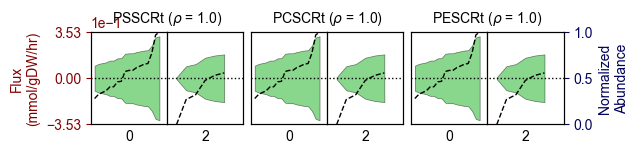

In [296]:
fluxes_to_plot = np.atleast_2d(
    np.array(
        [
            # ['SERHL', "CYSL2"],
            # ['G6PDH2'],
            # ['PPM'],
            # ['ADK1'],
            # ['DTHYMy'],
            # ['PAFS', 'LPCOAT', 'LPCPAT'],
            # ['PROTSPP', 'PROTTPP'],
            # ['PSFLIPt', 'PEFLIPt'],
            # ['PCFLOPt', "SMFLOPt"],
            # ['DTHYMy', 'DURADy'],
            ['PSSCRt', 'PCSCRt', 'PESCRt'],


        ],
    )
)
optimums = [0]
sharex = True
sharey = "row"
supylabel = False
plot_as_bar = False
min_max_norm_flux = False
min_max_norm_abundance = True
include_abundance_line = True
width_scalar = 1
height_scalar = 0.8
fontsizes_dict = dict(
    xlabel=10,
    xticks=10,
    ylabel=10,
    yticks=10,
    title=12,
)
panel_kwargs = dict(
    # Only for bar plot
    width=1, # Bar width
    linewidth=0.5, # Edgewidth of bars
    edgecolor="black", # Color of edge width
    # Both plots
    alpha=0.5, 
    zorder=2,
    maxnum_yticks=3,
    # Equilibrium line
    equilibrium_lineprops=dict(
        color="black",
        linestyle=":",
        linewidth=1,
    )
)
flux_str = "Normalized\nFlux" if min_max_norm_flux else "Flux\n(mmol/gDW/hr)"
abundance_str = "Normalized\nAbundance" if min_max_norm_abundance else "Abundance\n(nmol/gDW)"
ordered_model_groups = {group: model_groups[group] for group in ordered_groups_to_compare}
xlabels_dict = {group: group.replace(main_group_name, "").strip("_") for group in list(ordered_model_groups)}
ylabels_dict = {reaction: flux_str for reaction in fluxes_to_plot.flatten() if reaction} if not supylabel else {}
ylabels_dict = {}
titles_dict = {
    reaction: reaction + (" ($\\rho$ = " + "{})".format(round(reaction_correlations[reaction], 4)) if reaction_correlations and reaction_correlations.get(reaction) else "") 
    for reaction in fluxes_to_plot.flatten() if reaction
}
# titles_dict = {}
fig, all_axes = create_flux_range_figure_axes(
    *fluxes_to_plot.shape,
    len(ordered_model_groups),
    width_scalar=width_scalar, # * (fluxes_to_plot.shape[0]),
    height_scalar=height_scalar,# * (fluxes_to_plot.shape[1] + hspace),
    hspace=0.5 if sharex else 1,
    wspace=0.05 if sharey else 0.5,
)

for row_idx, (row_rxns, row_axes) in enumerate(zip(fluxes_to_plot, all_axes)):
    for col_idx, (reaction, axes) in enumerate(zip(row_rxns, row_axes)):
        df_data_reaction = df_data_groups_to_compare.loc[reaction].copy()
        if min_max_norm_flux:
            df_data_reaction["norm_range"] = ((df_data_reaction["range"] - df_data_reaction["range"].min()) / (df_data_reaction["range"].max() - df_data_reaction["range"].min())).fillna(0)
            ylims = (0, 1 + ypad_percent)
        elif sharey:
            rxn_list = row_rxns if sharey == "row" else fluxes_to_plot.flatten()
            df_ylim = df_data_groups_to_compare.loc[[x for x in rxn_list if x]]
            ylims = (
                df_ylim["min"].min() - abs(df_ylim["min"].min() * ypad_percent), 
                df_ylim["max"].max() + abs(df_ylim["max"].max() * ypad_percent), 
            )
        else:
            ylims = (
                df_data_reaction["min"].min() - abs(df_data_reaction["min"].min() * ypad_percent), 
                df_data_reaction["max"].max() + abs(df_data_reaction["max"].max() * ypad_percent), 
            )
        for panel_idx, ((group, sample_list), ax_panel) in enumerate(zip(ordered_model_groups.items(), axes)):
            # Get samples for group and order by donor number 
            df_data_group = df_data_reaction.loc[sample_list]
            # Get data for ooptimums
            xlims = (0, len(df_data_group.index.unique()))
            for optimum in optimums:
                df = df_data_group[df_data_group["optimum"] == optimum].drop("optimum", axis=1)
                # Rank order results within the optimum if desired
                df = df.sort_values(by=list(rank_order_results), ascending=list(rank_order_results.values()) if isinstance(rank_order_results, dict) else True)
                ax_panel = plot_flux_range_panel(
                    x=np.arange(*xlims),
                    min_values=df["min"].values if not min_max_norm_flux else df["min"].values - df["min"].values,
                    max_values=df["max"].values if not min_max_norm_flux else df["norm_range"].values,
                    ax=ax_panel,
                    bar=plot_as_bar,
                    color=optimum_colors.get(optimum, "xkcd:light green"),
                    **panel_kwargs
                )
            
            if include_abundance_line:
                abundance_values = df_data_reaction.groupby(level=0)["abundance"].max()
                if min_max_norm_abundance:
                    abundance_values = ((abundance_values - abundance_values.min()) / (abundance_values.max() - abundance_values.min())).fillna(0)
                    aylims = (0, 1)
                elif sharey:
                    rxn_list = row_rxns if sharey == "row" else fluxes_to_plot.flatten()
                    aylims = (df_data_groups_to_compare.loc[[x for x in rxn_list if x]]["abundance"].min(), df_data_groups_to_compare.loc[[x for x in rxn_list if x]]["abundance"].max())
                    aylims = (
                        aylims[0]- (aylims[0] * ypad_percent), 
                        aylims[1] + (aylims[1] * ypad_percent), 
                    )
                else:
                    aylims = (
                        0 - (df_data_reaction["abundance"].max() * ypad_percent), 
                        df_data_reaction["abundance"].max() + (df_data_reaction["abundance"].max() * ypad_percent)
                    )

                ax_abundance = plot_abundance_line(
                    x=np.arange(*xlims), 
                    y=abundance_values.loc[df.index].copy(), 
                    ax=ax_panel.twinx(), 
                    xlims=(xlims[0] - panel_kwargs.get("xlim_pad", 1), xlims[1] + panel_kwargs.get("xlim_pad", 1)),
                    ylims=aylims,
                    **abundance_kwargs,
                )
                if (panel_idx == len(ordered_model_groups) -1) and ((sharey and col_idx == fluxes_to_plot.shape[1] - 1) or not sharey):
                    ylabel = abundance_str if not supylabel else None
                    if min_max_norm_abundance:
                        ax_abundance.set_yticks(np.linspace(0, 1, panel_kwargs.get("maxnum_yticks", 3)))
                    elif panel_kwargs.get("maxnum_yticks"):
                        ax_abundance.set_yticks(np.linspace(ax_abundance.get_ybound()[0], ax_abundance.get_ybound()[1], panel_kwargs.get("maxnum_yticks", 3)))
                    ax_abundance.set_ylabel(ylabel, fontsize=fontsizes_dict.get("ylabel", "large"), va="center", labelpad=15, color=abundance_label_color)
                    ax_abundance.yaxis.set_tick_params(labelsize=fontsizes_dict.get("yticks", "large"), labelright=True, colors=abundance_label_color)
                else:
                    ax_abundance.set_ylabel(None)
                    ax_abundance.set_yticks([])
                    ax_abundance.yaxis.set_tick_params(labelright=False)
        
            # Format panel, lot of conditional inputs depending on where panel is and whether multiple rows/columns are present.
            format_panel_for_group(
                ax_panel, 
                panel_idx=panel_idx,
                xaxis_dict=dict(
                    # Add extra padding for limits
                    lim=(xlims[0] - panel_kwargs.get("xlim_pad", 1), xlims[1] + panel_kwargs.get("xlim_pad", 1)),
                    label=xlabels_dict.get(group)  if ((row_idx == fluxes_to_plot.shape[0]-1 and sharex) or not sharex) else None,
                ), 
                
                yaxis_dict=dict(
                    lim=ylims,
                    label=ylabels_dict.get(reaction, flux_str) if (not supylabel and ((col_idx == 0 and sharey) or not sharey)) else None,
                    va="center",
                    labelpad=15,
                    color=flux_label_color if include_abundance_line else "black",
                    maxnum_yticks=panel_kwargs.get("maxnum_yticks", 3),
                    ticklabel_format=dict(style='sci', scilimits=(0,0))

                ), 
                fontsizes_dict=fontsizes_dict,
                seperator_spine_color="xkcd:grey",
                min_max_norm_flux=min_max_norm_flux,
            )
            if panel_idx == 0 and ((col_idx != 0 and sharey) or not sharey):
                ax_panel.yaxis.set_tick_params(labelleft=False)
                ax_panel.set_yticks([])
            if panel_idx == (len(ordered_model_groups) - 1)/2 or (len(ordered_model_groups) % 2 == 0 and panel_idx % 2 == 0):
                if panel_idx == (len(ordered_model_groups) - 1)/2: # Odd number of panels
                    ax_panel.set_title(titles_dict.get(reaction, reaction), fontsize=fontsizes_dict.get("title", "xx-large"))
                else: # Even number of panels
                    ax_panel.text(x=1, y=1.1, s=titles_dict.get(reaction, reaction), transform=ax_panel.transAxes, ha="center")
if supylabel:
    # Adjust manually
    text = fig.text(x=0.02 + 0.025*fluxes_to_plot.shape[1], y=0.5, s=flux_str, ha="center", va="center", 
                    fontsize=fontsizes_dict.get("supylabel", "xx-large"), color=flux_label_color if include_abundance_line else "black", rotation="vertical")
    if include_abundance_line:
        fig.text(x=1.0 - 0.025*fluxes_to_plot.shape[1], y=0.5, s=abundance_str, ha="center", va="center", 
                 fontsize=fontsizes_dict.get("supylabel", "xx-large"), color=abundance_label_color, rotation="vertical")

fig.align_xlabels()
fig.align_ylabels()
plt.show()
if save_figures:
    rxns = "_".join(fluxes_to_plot.flatten())    
    fig_dirpath = group_results_dirpath_dict[all_key] / "fluxranges" / "_".join(ordered_groups_to_compare)
    fig_dirpath.mkdir(exist_ok=True, parents=True)
    fig.savefig(
        fig_dirpath / f"fluxes_{rxns}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig

In [258]:
model.metabolites.sphings_c

Metabolite identifier,sphings_c
Name,Sphingosine (SPB 18:1;O2)
Memory address,0x29feeeff1d0
Formula,C18H38NO2
Compartment,c
In 4 reaction(s),"ACER, SPHS1PP, SPHGNSK, SPHGNSte"


In [234]:
model.reactions.

Reaction identifier,SMPD
Name,Sphingomyelin phosphodiesterase
Memory address,0x29ff056d9d0
Stoichiometry,h2o_c + sphmyln_hs_c --> cholp_c + crm_hs_c + h_c H2O + SM --> Phosphocholine + Ceramide (Cer d18:2) + H+
GPR,SMPD1 or SMPD3
Lower bound,0.0
Upper bound,1000.0
